# 🔍 ChromaDB Viewer

Notebook per visualizzare e esplorare il contenuto del database ChromaDB.

In [1]:
import sys
from pathlib import Path

# Aggiungi source al path per importare i moduli
sys.path.insert(0, str(Path("../source").resolve()))

from AI_RM import EmbeddingStore, Embedder, default_config
print("Moduli caricati")

Moduli caricati


## 1. Connessione al Database

In [2]:
# Inizializza lo store
store = EmbeddingStore(config=default_config.vector_store)

# Mostra statistiche
stats = store.get_stats()
print(f"Database Statistics")
print(f"\tCollection: {stats.collection_name}")
print(f"\tDocuments: {stats.total_documents}")
print(f"\tPath: {stats.persist_path}")
print(f"\tMetric: {stats.distance_metric}")

Database Statistics
	Collection: krss_videos
	Documents: 135
	Path: /app/data/embeddings/chroma_db
	Metric: cosine


## 2. Visualizza Sample di Video

In [3]:
# Mostra alcuni video casuali
samples = store.sample(n=5)

if samples:
    print("Sample Videos:")
    for i, s in enumerate(samples, 1):
        print(f"\n{i}. {s['video_id']}")
        print(f"\tText: {s['text']}")
        print(f"\tCategory: {s['metadata'].get('category', 'N/A')}")
        print(f"\tChannel: {s['metadata'].get('channel_name', 'N/A')}")
else:
    print("Database vuoto! Esegui prima il notebook 02_chromadb_setup.ipynb")

Sample Videos:

1. itRV2jEtV8Q
	Text: Simulating and understanding phase change | Guest video by Vilas Winstein. Deriving the Boltzmann fo...
	Category: Education
	Channel: 3Blue1Brown

2. cdu6sOgI9Dc
	Text: My Weirdest Dice....
	Category: Entertainment
	Channel: Vsauce

3. FE-hM1kRK4Y
	Text: Why Laplace transforms are so useful. Studying the forced harmonic oscillator by taking a Laplace tr...
	Category: Education
	Channel: 3Blue1Brown

4. XX8mjBXBqz8
	Text: Testing your intuition for quantum computing. Full video: https://youtu.be/RQWpF2Gb-gU...
	Category: Education
	Channel: 3Blue1Brown

5. skmqR_VMECQ
	Text: The Return of Festive Flashing Lights - Computerphile. Steve gets all festive and tries to improve o...
	Category: Education
	Channel: Computerphile


## 3. Esporta come DataFrame

In [4]:
# Esporta il DB come DataFrame per analisi
import pandas as pd

# Ottieni un DataFrame dal store (contiene id, text, metadata, ecc.)
df = store.to_dataframe()
display(df.head())
print(f'Totale video nel DB: {len(df)}')

# Esempio: crea una lista di categorie dall'indice metadata
# categories = df['metadata'].apply(lambda m: m.get('category', 'Unknown')) if 'metadata' in df.columns else None

# Nota: non reinserire dati nel DB da questo notebook; questo viewer è solo per esplorazione.

,video_id,text,channel_id,category,published_at,title,channel_name
0,FE-hM1kRK4Y,Why Laplace transforms are so useful. Studying...,UCYO_jab_esuFRV4b17AJtAw,Education,2025-11-05T13:09:45+00:00,Why Laplace transforms are so useful,3Blue1Brown
1,bnjKwiUg-kw,The dynamics of e^(πi). A fuller version of th...,UCYO_jab_esuFRV4b17AJtAw,Education,2025-10-12T12:40:46+00:00,The dynamics of e^(πi),3Blue1Brown
2,j0wJBEZdwLs,But what is a Laplace Transform?. Visualizing ...,UCYO_jab_esuFRV4b17AJtAw,Education,2025-10-12T11:19:53+00:00,But what is a Laplace Transform?,3Blue1Brown
3,-j8PzkZ70Lg,The Physics of Euler's Formula | Laplace Trans...,UCYO_jab_esuFRV4b17AJtAw,Education,2025-10-05T13:53:28+00:00,The Physics of Euler's Formula | Laplace Trans...,3Blue1Brown
4,M-MgQC6z3VU,What was Euclid really doing? | Guest video by...,UCYO_jab_esuFRV4b17AJtAw,Education,2025-09-18T14:13:05+00:00,What was Euclid really doing? | Guest video by...,3Blue1Brown


Totale video nel DB: 135


## 4. Distribuzione per Categoria

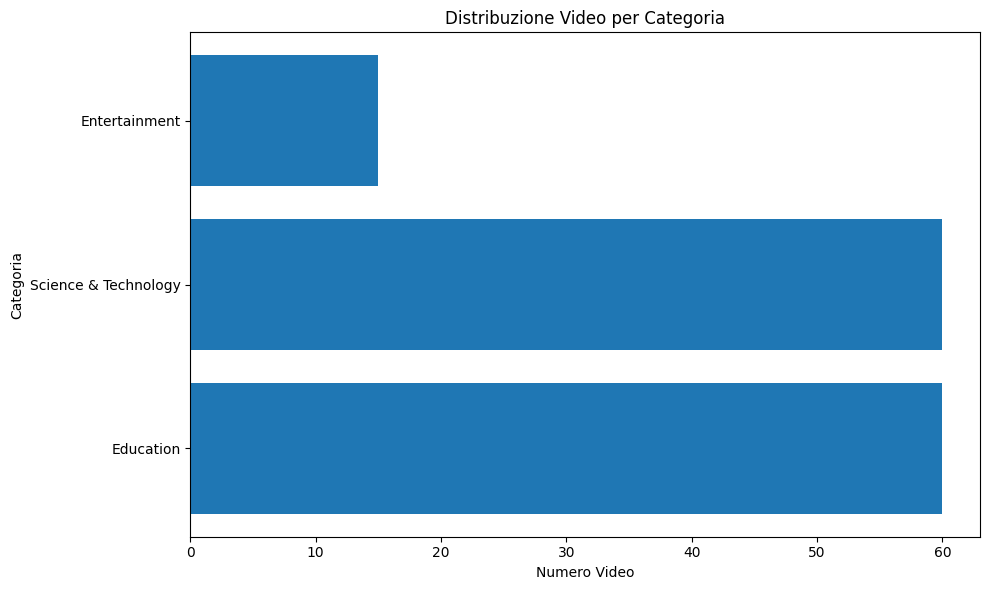


Dettaglio:
   Education: 60
   Science & Technology: 60
   Entertainment: 15


In [5]:
import matplotlib.pyplot as plt

categories = store.get_category_distribution()

if categories:
    plt.figure(figsize=(10, 6))
    plt.barh(list(categories.keys()), list(categories.values()))
    plt.xlabel('Numero Video')
    plt.ylabel('Categoria')
    plt.title('Distribuzione Video per Categoria')
    plt.tight_layout()
    plt.show()
    
    print("\nDettaglio:")
    for cat, count in sorted(categories.items(), key=lambda x: -x[1]):
        print(f"   {cat}: {count}")
else:
    print("Nessuna categoria trovata")

## 5. Distribuzione per Canale

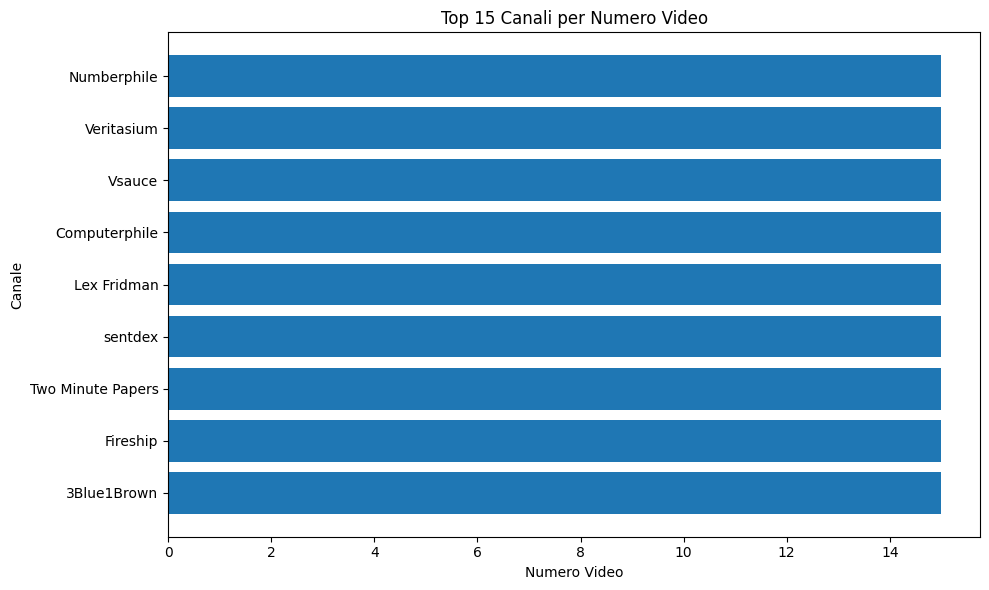

In [6]:
channels = store.get_channel_distribution()

if channels:
    # Top 15 canali
    top_channels = dict(sorted(channels.items(), key=lambda x: -x[1])[:15])
    
    plt.figure(figsize=(10, 6))
    plt.barh(list(top_channels.keys()), list(top_channels.values()))
    plt.xlabel('Numero Video')
    plt.ylabel('Canale')
    plt.title('Top 15 Canali per Numero Video')
    plt.tight_layout()
    plt.show()
else:
    print("Nessun canale trovato")

## 6. Test Ricerca Semantica

In [7]:
# Inizializza embedder per le query (usa la config centrale)
embedder = Embedder(config=default_config.embedding)

def search(query: str, n: int = 5, category: str = None):
    """Funzione helper per cercare video."""
    query_emb = embedder.encode(query)
    where_filter = {"category": category} if category else None
    
    results = store.search(
        query_embedding=query_emb,
        n_results=n,
        where=where_filter
    )
    
    print(f"Query: '{query}'")
    if category:
        print(f"\tFilter: category = '{category}'")
    print(f"\nRisultati ({len(results)}):")
    
    for i, r in enumerate(results, 1):
        print(f"\n{i}. [{r.score:.3f}] {r.text[:70]}...")
        print(f"   ID: {r.video_id}")
        print(f"   Channel: {r.metadata.get('channel_name', 'N/A')}")
        print(f"   Category: {r.metadata.get('category', 'N/A')}")

In [8]:
# Esempio di ricerca
search("mathematic", n=5)

Query: 'mathematic'

Risultati (5):

1. [0.316] The Real Story of Calculus - Numberphile. This video features Swagat S...
   ID: G23Jx0kPCSI
   Channel: Numberphile
   Category: Science & Technology

2. [0.251] Infinity, Paradoxes, Gödel Incompleteness & the Mathematical Multivers...
   ID: 14OPT6CcsH4
   Channel: Lex Fridman
   Category: Science & Technology

3. [0.239] Only Using Words That Begin With "A"....
   ID: za2isHAgefY
   Channel: Vsauce
   Category: Entertainment

4. [0.234] The AI that solved IMO Geometry Problems | Guest video by @Aleph0. How...
   ID: 4NlrfOl0l8U
   Channel: 3Blue1Brown
   Category: Education

5. [0.227] The Secret of the Raffle Function (epic proof) - Numberphile. Zvezdeli...
   ID: XhA5U9pFXuU
   Channel: Numberphile
   Category: Science & Technology


In [9]:
# Ricerca con filtro categoria
search("machine learning", n=3, category="Education")

Query: 'machine learning'
	Filter: category = 'Education'

Risultati (3):

1. [0.352] Gen AI & Reinforcement Learning- Computerphile. The real-world doesn't...
   ID: LHsgtcNNM0A
   Channel: Computerphile
   Category: Education

2. [0.347] Code Optimisation via Memoization - Computerphile. Learn this caching ...
   ID: JXUOMsFBDXQ
   Channel: Computerphile
   Category: Education

3. [0.304] The Hard Problem of Controlling Powerful AI Systems - Computerphile. A...
   ID: JAcwtV_bFp4
   Channel: Computerphile
   Category: Education


## 7. Lookup Video Specifico

In [10]:
# Cerca un video specifico per ID
# Sostituisci con un ID reale dal tuo database

video_id = df['video_id'].iloc[0] if not df.empty else None

if video_id:
    video = store.get_video(video_id)
    if video:
        print(f"Video: {video_id}")
        print(f"\nText: {video['text'][:200]}...")
        print(f"\nMetadata: {video['metadata']}")
        print(f"\nEmbedding shape: {video['embedding'].shape if video['embedding'] is not None else 'N/A'}")
else:
    print("Nessun video nel database")

Video: FE-hM1kRK4Y

Text: Why Laplace transforms are so useful. Studying the forced harmonic oscillator by taking a Laplace transform and studying its poles.
Instead of sponsored ad reads, these lessons are funded directly by ...

Metadata: {'published_at': '2025-11-05T13:09:45+00:00', 'channel_name': '3Blue1Brown', 'category': 'Education', 'channel_id': 'UCYO_jab_esuFRV4b17AJtAw', 'title': 'Why Laplace transforms are so useful'}

Embedding shape: (384,)
